# Identifying the Drivers of Churn at Telco
***
# Goals

My goal for this project is to create a model that will acurrately predict customer churn using the customer data provided. I will also be identifying the primary drivers of customer churn.

I will deliver classification_project.ipynb, README.md, predictions.csv, acquire.py, prepare.py, model.py, a walkthrough-style presentation of the project. The deliverables listed here are detailed in-depth in the README file.

A link to the presentation slides can be found below.

https://docs.google.com/presentation/d/1fI64dzhV6jX33lD-tAv9IEc0MOXx1_ilWL54OKl9aRQ/edit?usp=sharing


# Acquire
Acquire data from the customers table from the telco_churn database on the codeup data science database server.
***

In [ ]:
# preparing environment
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

#import acquire as ac
from acquire import get_telco_data
from prepare import prepare_telco

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score

In [2]:
# display data frame
df = get_telco_data()

df.head(3)

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service_type_id,online_security,...,device_protection,tech_support,streaming_tv,streaming_movies,contract_type_id,paperless_billing,payment_type_id,monthly_charges,total_charges,churn
0,0002-ORFBO,Female,0,Yes,Yes,9,Yes,No,1,No,...,No,Yes,Yes,No,2,Yes,2,65.6,593.3,No
1,0003-MKNFE,Male,0,No,No,9,Yes,Yes,1,No,...,No,No,No,Yes,1,No,2,59.9,542.4,No
2,0004-TLHLJ,Male,0,No,No,4,Yes,No,2,No,...,Yes,No,No,No,1,Yes,1,73.9,280.85,Yes


# Prepare
Prepare, tidy, and clean the data so it can be explored and analyzed
***

In [3]:
# displaying column names, dtypes, etc.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               7043 non-null   object 
 1   gender                    7043 non-null   object 
 2   senior_citizen            7043 non-null   int64  
 3   partner                   7043 non-null   object 
 4   dependents                7043 non-null   object 
 5   tenure                    7043 non-null   int64  
 6   phone_service             7043 non-null   object 
 7   multiple_lines            7043 non-null   object 
 8   internet_service_type_id  7043 non-null   int64  
 9   online_security           7043 non-null   object 
 10  online_backup             7043 non-null   object 
 11  device_protection         7043 non-null   object 
 12  tech_support              7043 non-null   object 
 13  streaming_tv              7043 non-null   object 
 14  streamin

- Categorical object variables such as gender, churn and dependents may need to be converted to 0s and 1s
- No missing values
    - Values with only white space may exist however
- Rename tenure to reflect unit of measurement
- Convert total_charges to float

In [4]:
# displaying various values for numerical columns (average, quartiles, min, max, etc)
# this allows us to get a rough idea of the values within the columns
df.describe().T

,count,mean,std,min,25%,50%,75%,max
senior_citizen,7043.0,0.162147,0.368612,0.00,0.0,0.00,0.00,1.00
tenure,7043.0,32.371149,24.559481,0.00,9.0,29.00,55.00,72.00
internet_service_type_id,7043.0,1.872923,0.737796,1.00,1.0,2.00,2.00,3.00
contract_type_id,7043.0,1.690473,0.833755,1.00,1.0,1.00,2.00,3.00
payment_type_id,7043.0,2.315633,1.148907,1.00,1.0,2.00,3.00,4.00
monthly_charges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75


- Senior_citizen: seniors are a minority
- Tenure: 72 month max means we have no records older than 6 years
- Type_ids for internet_service, contract, and paymenta are already numerical so no need to convert
- Monthly_charges: the average monthly payment is 64.76

In [5]:
# displaying unique values per column to identify categorical variables
for col in df:
    if col != 'customer_id' and col != 'total_charges' and col != 'monthly_charges' and col != 'tenure':
        print(df[col].value_counts())

Male      3555
Female    3488
Name: gender, dtype: int64
0    5901
1    1142
Name: senior_citizen, dtype: int64
No     3641
Yes    3402
Name: partner, dtype: int64
No     4933
Yes    2110
Name: dependents, dtype: int64
Yes    6361
No      682
Name: phone_service, dtype: int64
No                  3390
Yes                 2971
No phone service     682
Name: multiple_lines, dtype: int64
2    3096
1    2421
3    1526
Name: internet_service_type_id, dtype: int64
No                     3498
Yes                    2019
No internet service    1526
Name: online_security, dtype: int64
No                     3088
Yes                    2429
No internet service    1526
Name: online_backup, dtype: int64
No                     3095
Yes                    2422
No internet service    1526
Name: device_protection, dtype: int64
No                     3473
Yes                    2044
No internet service    1526
Name: tech_support, dtype: int64
No                     2810
Yes                    2707
No in

- convert columns with 2 values to 0s and 1s
- "no x service" values can be converted to "No" (soon to be 0)

__Outliers and distributions__

In [ ]:
# plotting data to identify outliers and distributions
for col in df.columns:
    if col != 'customer_id':
        plt.figure(figsize=(4,3))
        plt.hist(df[col])
        plt.title(col)
        plt.show()

- No outliers found
- Customers without phone service and seniors are minorities
- Fairly even split between male and female
- Monthly_charges would be a somewhat normal distribution if not for the extremely high amount of low payment customers

### Preparing data with changes outlined in prepare takeaways

In [7]:
train, validate, test = prepare_telco(get_telco_data())

### Prepare Takeaways

- converted object columns with binary values to 0s and 1s
- renamed gender column to female (female = 1)
- renamed tenure to tenure_months
- added column for tenure years
- removed duplicates
- converted total_charges to float
- no null values found
- 11 white space values in total_charges filed with 0 since client has not been charged yet
- split into train, validate, test

# Explore
We begin exploring our prepped data to identify drivers of churn and relationships between variables.
***

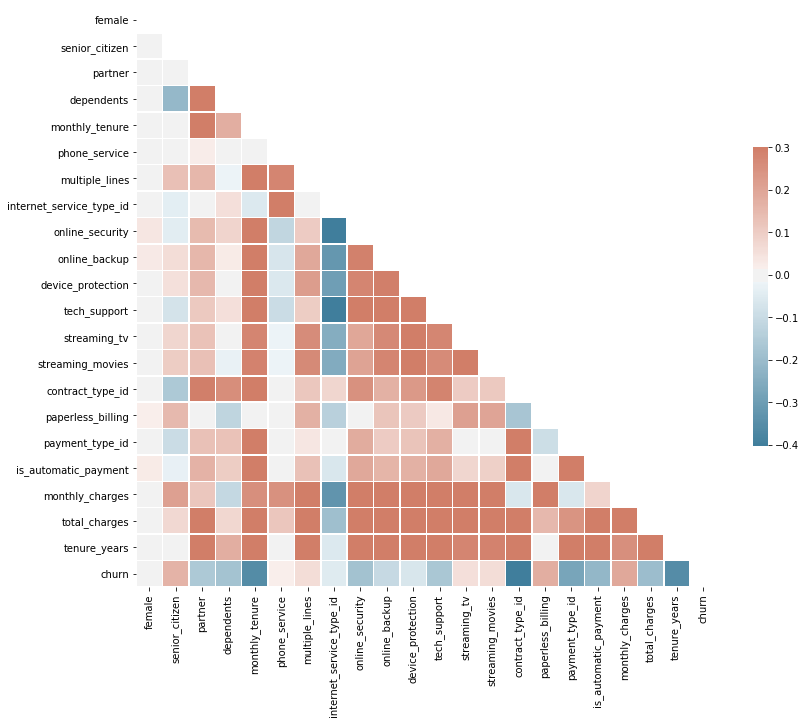

In [8]:
# creating a heatmap that will show each features correlation to one another
# specifically, we are interested in the correlation between churn and each other feature
corr = train.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(13, 11))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Exploring Individual Variables
Note: For all hypothesis tests, all assumptions were met. In cases of differing variance, the equal_var argument was set to "false".
***

## Variable: Monthly_Charge
Our clients may be cost sensitive and as a result, they may be leaving us in order to save money by paying less to a competitor.
***

### Monthly_charge (Plot)

 Lets plot to see if a majority clients who have churned have also had high monthly charges. 

In [ ]:
# setting figure size
plt.figure(figsize=(14,12))

# plotting churned customer monthly charges data
plt.subplot(221)
churn_vs_monthly_charges = train[train.churn == 1].monthly_charges
churn_vs_monthly_charges.hist(color='orange')
plt.xlabel('monthly_charge', fontsize = 20)
plt.ylabel('# of clients', fontsize = 20)
plt.title('Churned Clients', fontsize = 20)

# plotting non-churned customer monthly charges data
plt.subplot(222)
churn_vs_monthly_charges = train[train.churn == 0].monthly_charges
churn_vs_monthly_charges.hist(color = 'green')
plt.xlabel('monthly_charge', fontsize = 20)
plt.ylabel('# of clients', fontsize = 20)
plt.title('Non-Churned Clients', fontsize = 20)

Plot takeaway: It appears that clients who have churned payed more per month that clients who have not churned.

### Monthly_charge (Hypothesis Test)
We'll now run a hypothesis test to confirm if our findings from the plots are valid.

Idea: I believe churned clients have had higher monthly charges on average than clients who have not churned
<br>
H0: Churned customer average monthly_charges <=  Non-Churned customer average monthly_charges
<br>
Ha: Churned customer average monthly_charges >  Non-Churned customer average monthly_charges

In [ ]:
# Running a one-tailed, two-sample t-test to test hypothesis

# setting alpha
test_1_alpha = .05

# creating DFs for churned and non-churned monthly charges
churn_monthly_charge = train[(train.churn == 1)].monthly_charges
no_churn_monthly_charge = train[(train.churn == 0)].monthly_charges

# running test
t_1, p_1 = stats.ttest_ind(churn_monthly_charge, no_churn_monthly_charge, equal_var = False)

# printing results
print('t = ',t_1,'\n')
print('p = ',p_1/2,'\n')

if p_1/2 > test_1_alpha:
    print('We fail to reject H0, there is no difference in monthly charges between churned and non-churned clients')
elif t_1 < 0:
    print('We fail to reject H0, there is no difference in monthly charges between churned and non-churned clients')
else:
    print('t > 0 and p < alpha so we reject the null hypothesis.')

###  Monthly Charges Takeaways
- Our plots and hypothesis test found that churned clients were paying more per month than our non-churned customers on average.
- This suggests our customers are price sensitive and high monthly charges are driving churn.

## Variable: Partner
Partners being on an account together can create an exit barrier for clients because they prefer to be on an account with their partner and don't want to have to both go through the process of signing up for a new service. 
***

### Partner (Plot)

Lets plot to see if clients who have a partner on their account stay with us longer than clients without partners.

In [ ]:
# setting figure size
plt.figure(figsize=(14,12))

# creating plot of clients w/partner monthly tenure
plt.subplot(221)
partner_tenure = (train[train.partner == 1].monthly_tenure)
partner_tenure.hist(color = 'purple')
plt.xlabel('monthly_tenure', fontsize = 20)
plt.ylabel('# of clients', fontsize = 20)
plt.title('Clients w/ Partner', fontsize = 20)

# creating plot of clients w/partner monthly tenure
plt.subplot(222)
no_partner_tenure = (train[train.partner == 0].monthly_tenure)
no_partner_tenure.hist(color = 'teal')
plt.xlabel('monthly_tenure', fontsize = 20)
plt.ylabel('# of clients', fontsize = 20)
plt.title('Clients w/o Partner', fontsize = 20)

Plot takeaway: Clients with partners on their accounts seem to have higher monthly tenure than clients without partners. In other words, they stay with us longer.

### Partner (Hypothesis Test)
We'll now run a hypothesis test to confirm if our findings from the plots are valid.

Idea: Clients with partners stay with us longer than those without partners.
<br>
H0: Average monthly tenure of clients with partners <= monthly tenure of clients without partners
<br>
Ha: Average monthly tenure of clients with partners > monthly tenure of clients without partners

In [ ]:
# Running a one-tailed, two-sample t-test to test hypothesis

# setting alpha
test_2_alpha = .05

# creating DFs for monthly tenure of clients with and without partners
partner_tenure = train[(train.partner == 1)].monthly_tenure
nopartner_tenure = train[(train.partner == 0)].monthly_tenure

# running t-test
t_2, p_2 = stats.ttest_ind(partner_tenure, nopartner_tenure, equal_var = False)


# printing results
print('t = ',t_2,'\n')
print('p = ',p_2/2,'\n')

if p_2/2 > test_2_alpha:
    print('We fail to reject H0, there is no difference in monthly tenure between clients with partners and those without')
elif t_2 < 0:
    print('We fail to reject H0, there is no difference in monthly tenure between clients with partners and those without')
else:
    print('t > 0 and p < alpha so we reject the null hypothesis.')

### Partner Takeaways
- Our plots and hypothesis test found that clients with partners have longer monthly tenures than those without partners. In other words, clients with partners tend to stay with us longer.
- This suggests our customers are motivated to stay with us when their partner is on their account because they'd prefer to avoid the process of switching over both of their services a different provider.

## Variable: Dependents
Just as having a partner on an account can create an exit barrier for a customer, the same can hold true for dependents. Our clients may prefer to remain with us in order to avoid having to switch all of their depedents along with themselves to a new service.
***

### Depedents (plot)
Lets plot to see if clients who have a partner on their account stay with us longer than clients without partners.

In [ ]:
# setting figure size
plt.figure(figsize=(14,12))

# creating plot of clients w/dependents monthly tenure
plt.subplot(221)
dependent_tenure = (train[train.dependents == 1].monthly_tenure)
dependent_tenure.hist(color = 'cyan')
plt.xlabel('monthly_tenure', fontsize = 20)
plt.ylabel('# of clients', fontsize = 20)
plt.title('Clients w/ dependent', fontsize = 20)

# creating plot of clients w/dependents monthly tenure
plt.subplot(222)
no_dependent_tenure = (train[train.dependents == 0].monthly_tenure)
no_dependent_tenure.hist(color = 'brown')
plt.xlabel('monthly_tenure', fontsize = 20)
plt.ylabel('# of clients', fontsize = 20)
plt.title('Clients w/o dependent', fontsize = 20)

Plot takeaway: Clients with dependents on their accounts seem to have higher monthly tenure than clients without dependents. In other words, they stay with us longer.

### Dependent (Hypothesis Test)
We'll now run a hypothesis test to confirm if our findings from the plots are valid.

Idea: Clients with dependents stay with us longer than those without dependents.

H0: Monthly tenure of clients with dependents <= monthly tenure of clients without dependents
<br>
Ha: Monthly tenure of clients with dependents > monthly tenure of clients without dependents

In [ ]:
# Running a one-tailed, two-sample t-test to test hypothesis

# setting alpha
test_3_alpha = .05

# creating DFs for monthly tenure of clients with and without dependents
dependent_tenure = train[(train.dependents == 1)].monthly_tenure
nodependent_tenure = train[(train.dependents == 0)].monthly_tenure

# running t-test
t_3, p_3 = stats.ttest_ind(dependent_tenure, nodependent_tenure, equal_var = False)


# printing results
print('t = ',t_3,'\n')
print('p = ',p_3/2,'\n')

if p_3/2 > test_3_alpha:
    print('We fail to reject H0, there is no difference in monthly tenure between clients with dependents and those without')
elif t_3 < 0:
    print('We fail to reject H0, there is no difference in monthly tenure between clients with dependents and those without')
else:
    print('t > 0 and p < alpha so we reject the null hypothesis.')

### Dependents Takeaways
- Our plots and hypothesis test found that clients with dependents have longer monthly tenures than those without dependents. In other words, clients with dependents tend to stay with us longer.
- This suggests our customers are motivated to stay with us when a dependent is on their account because they'd prefer to avoid the process of switching over both of their services to a different provider.

## Varialbe: Automatic_payment
***
Convenience is a major selling point for many consumers. The vlaue our clients' glean from using our automatic payment methods may play a significant role in our ability to retain them

### Automatic_payment (plot)
Lets plot to see if clients who use automatic payments stay with us longer than clients who make payments manually.

In [ ]:
# setting figure size
plt.figure(figsize=(14,12))

# creating plot of clients w/automatic payment monthly tenure
plt.subplot(221)
automatic_tenure = (train[train.is_automatic_payment == 1].monthly_tenure)
automatic_tenure.hist(color = 'skyblue')
plt.xlabel('monthly_tenure', fontsize = 20)
plt.ylabel('# of clients', fontsize = 20)
plt.title('Clients w/ Automatic Payments', fontsize = 20)

# creating plot of clients w/manual payment monthly tenure
plt.subplot(222)
manual_tenure = (train[train.is_automatic_payment == 0].monthly_tenure)
manual_tenure.hist(color = 'violet')
plt.xlabel('monthly_tenure', fontsize = 20)
plt.ylabel('# of clients', fontsize = 20)
plt.title('Clients w/ Manual Payments', fontsize = 20)

Plot takeaway: Clients with dependents on their accounts seem to have higher monthly tenure than clients without dependents. In other words, they stay with us longer.

### Automatic Payment (Hypothesis Test)
We'll now run a hypothesis test to confirm if our findings from the plots are valid.

Idea: Clients who make payments automatically stay with us longer than those who make payments manually.
<br>
<br>
H0: Monthly tenure of clients making automatic payments <= monthly tenure of clients making payments manually 
<br>
Ha: Monthly tenure of clients making automatic payments > monthly tenure of clients making payments manually 

In [ ]:
# Running a one-tailed, two-sample t-test to test hypothesis

# setting alpha
test_4_alpha = .05

# creating DFs for monthly tenure of clients who make automatic and manual payments
automatic_tenure = train[(train.is_automatic_payment == 1)].monthly_tenure
manual_tenure = train[(train.is_automatic_payment  == 0)].monthly_tenure

# running t-test
t_4, p_4 = stats.ttest_ind(automatic_tenure, manual_tenure, equal_var = False)

# printing results
print('t = ',t_4,'\n')
print('p = ',p_4/2,'\n')

if p_4/2 > test_4_alpha:
    print('We fail to reject H0, there is no difference in monthly tenure between clients with automatic payments and those with manual.')
elif t_4 < 0:
    print('We fail to reject H0, there is no difference in monthly tenure between clients with automatic payments and those with manual.')
else:
    print('t > 0 and p < alpha so we reject the null hypothesis.')

### Automatic Payment Takeaways
- Our plots and hypothesis test found that clients who make payments automatically have longer monthly tenures than those who do so manually. In other words, clients with automatic payments tend to stay with us longer.
- This suggests our customers appreciate the convenience of automatic payments and find value in it.

## Variable: Senior_Citizen
Are seniors leaving leaving us sooner or later than non-seniors on average? (And thus churning faster)
<br>
<br>
H0: Monthly tenure of seniors = Monthly tenure of non seniors
<br>
Ha: Monthly tenure of seniors != Monthly tenure of non seniors

In [ ]:
alpha = .05
senior_tenure = train[(train.senior_citizen == 1)].monthly_tenure
nonsenior_tenure = train[(train.senior_citizen == 0)].monthly_tenure

t, p = stats.ttest_ind(senior_tenure, nonsenior_tenure, equal_var = False)

print('alpha = .05')
print(f'p: {p}')

print('\nSince p > alpha (.05), we fail to reject the null hypothesis. The monthly tenure of seniors is no different than the monthly tenure of non-seniors.')

- Hypothesis test shows there is no difference in monthly tenure between seniors and non-seniors. 
- Given this, I won't explore senior status further as a driver of churn.

## Variable: Paperless Billing
Are paperless billing customers leaving leaving us sooner or later than non-paperless billing customers on average? (And thus churning faster)
<br>
<br>
H0: Monthly tenure of paperless billing customers = Monthly tenure of non-paperless billing customers
<br>
Ha: Monthly tenure of paperless billing customers != Monthly tenure of non-paperless billing customers

In [ ]:
alpha = .05
paperless_tenure = train[(train.paperless_billing == 1)].monthly_tenure
nopaperless_tenure = train[(train.paperless_billing == 0)].monthly_tenure

t, p = stats.ttest_ind(paperless_tenure, nopaperless_tenure, equal_var = False)

print('alpha = .05')
print(f'p: {p}')

print('\nSince p > alpha (.05), we fail to reject the null hypothesis. The monthly tenure of paperless billing customers is no different than the monthly tenure of non-paperless billing customers.')

- Hypothesis test shows there is no difference in monthly tenure between paperless billing and non-paperless billing customers
- Given this, I won't explore paperless billing further as a driver of churn.

## Overall Exploration Takeaways

- These features were explored but were found to have weak or little connection to churn
    * senior_citizen
    * paperless_billing
<br>
<br>
- These features show strong connections to churn but I did not explore them further for various reasons
    * contract_type_id 
        * Can't change per project specifications
    * monthly_tenure / tenure_years 
        * Increases as churn lowers but we can only influence it by convincing clients to stay via other      features
    * total_charges
        * Builds up over time the longer a customer has been with us. Not something we can control directly.
<br>
<br>
- Via plotting and hypothesis testing I made the following discoveries:
    - Clients who have churned had larger monthly charges than those who have not churned
    - Clients with partners and/or dependants stay with Telco longer than those without
    - Clients who make automatic payments stay with Telco longer than those who make payments manually
<br>
<br>
- These findings suggest that the following are drivers of churn:
    - Large monthly charges (monthly_charges)
    - No partner on account (partner)
    - No dependents on account (dependents)
    - Making payments manually (is_payment_automatic)

# Modeling
We use these variables that we believe strongly correlate with churn to create a model that will allow us to predict churn
***

## Baseline
We'll now construct a baseline and gauge its accuracy to determine what accuracy an alternate model would need in order to be viable.
***

In [ ]:
# copying train DF since we're going to add a new column and we don't want to alter our train table just yet
train_bl = train

# adding "baseline_prediction column" that predicts no one will churn since not churning (0), is the most common value
train_bl['baseline_prediction'] = 0

train_bl.head()

In [ ]:
# calculating accuracy of baseline model
baseline_accuracy = (train_bl['baseline_prediction'] == train_bl['churn']).mean()

print('Accuracy of baseline model is',round(baseline_accuracy,2)*100,'%')

### Baseline Takeaways
- Since we are not prioritizing the detection of false positives, false negatives, true positives, or true negatives and our main goal is to build a model that accurately predicts whether a customer will churn or not, we will be focusing on accuracy.
- The baseline model's accuracy of 73% is the metric that our alternate models will need to surpass.

## Modeling (Training)
In this phase we will create 3 models that will attempt to predict which customers churn in the train data set. Any models that surpass the baseline model's accuracy (73%) will be taken to the next phase, validation.
***

## Model 1

__Name__: Model 1
<br>
<br>
__Type__: K-Nearest Neighbor
<br>
<br>
__Features__:
- is_automatic_payment
- dependents
- partner
- monthly_charges
<br>

__Hyper Parameters__:
- n_neighbors = 3
- weights = 'uniform'

In [ ]:
# creating logistic regression object
knn = KNeighborsClassifier(n_neighbors=5, weights = 'uniform')

# creating DF with selected features for logistic regression model
m1_X_train = train[['is_automatic_payment','dependents','partner','monthly_charges']]
m1_y_train = train['churn']

# fitting model to data
knn.fit(m1_X_train, m1_y_train)

# making predictions on x train
m1_y_pred = pd.DataFrame(knn.predict(m1_X_train))

# previewing predictions of model
m1_y_pred.head()

In [ ]:
print(classification_report(m1_y_train, m1_y_pred))

print("Model 1's accuracy is 80%.\n")
print('Baseline models accuracy surpassed by a fair margin (7%). This model will move to validation')

## Model 2

__Name__: Model 2
<br>
<br>
__Type__: Decision Tree
<br>
<br>
__Features__:
- is_automatic_payment
- monthly_charges
<br>

__Hyper Parameters__:
- max depth = 2

In [ ]:
# creating decision tree object
m2_dtree = DecisionTreeClassifier(max_depth = 3, random_state=123)

# creating DF with selected features for d tree
m2_X_train = train[['is_automatic_payment','monthly_charges']]
m2_y_train = train['churn']

# fitting d tree to data
m2_dtree.fit(m2_X_train, m2_y_train)

# making predictions about churn on train data
m2_y_pred = pd.DataFrame(m2_dtree.predict(m2_X_train))

# previewing predictions
m2_y_pred.head()

In [ ]:
print(classification_report(m2_y_train, m2_y_pred))

print("Model 2's accuracy is 73%.\n")
print("Baseline models accuracy matched. This model won't move to validation if our other model surpasses the baseline.")

## Model 3

__Name__: Model 3
<br>
<br>
__Type__: Logistic Regression
<br>
<br>
__Features__:
- is_automatic_payment
- dependents
- partner
- monthly_charges
<br>


__Hyper Parameters__:
None

__Note__: Changed model type to Logistic Regression from Decision Tree

In [ ]:
# creating logistic regression object
m3_logit = LogisticRegression(random_state=123)

# creating DF with selected features for logistic regression model
m3_X_train = train[['is_automatic_payment','dependents','partner','monthly_charges']]
m3_y_train = train['churn']

# fitting model to data
m3_logit.fit(m3_X_train, m3_y_train)

# making predictions on train dataset
m3_y_pred = pd.DataFrame(m3_logit.predict(m3_X_train))

# previewing predictions of model
m3_y_pred.head()

In [ ]:
print(classification_report(m3_y_train, m3_y_pred))

print('Model 3''s accuracy is 74%.\n')
print('Baseline models accuracy surpassed. This model may move to the validation.')

### Modeling (Training) Takeaways
- Baseline model accuracy: 73%
<br>
- Model 1 accuracy (training): 80%
<br>
- Model 2 accuracy (training): 73%
<br>
- Model 3 accuracy (training): 74%
<br>
<br>
- Models 1 and 3 outperformed the baseline, they will be used in the validation phase to discern which is our overall best model.

## Modeling (Validation)
We will now be applying our most promising models, models 2 and 3 to the validation dataset. This will give us an idea of how our models would perform on data they have not yet seen.
***

### Model 1 (K Nearest Neighbors)

In [ ]:
# creating DF with selected features for logistic regression model
m1_X_validate = validate[['is_automatic_payment','dependents','partner','monthly_charges']]
m1_y_validate = validate['churn']

# making predictions on x validate
m1_y_pred_val = pd.DataFrame(knn.predict(m1_X_validate))

# previewing predictions of model
m1_y_pred.head()

In [ ]:
print(classification_report(m1_y_validate, m1_y_pred_val))

print("Model 1's accuracy is 72%.\n")

print('The accuracy of this model has dropped ~10% from the training dataset results.')
print('This is a sign that the model may have been overtuned and despite its solid performance earlier, its not consistent with data it has not seen before.')

### Model 3

In [ ]:
# creating DF with selected features for logistic regression model
m3_X_validate = validate[['is_automatic_payment','dependents','partner','monthly_charges']]
m3_y_validate = validate['churn']

# making predictions on validate dataset
m3_y_pred_val = pd.DataFrame(m3_logit.predict(m3_X_validate))

# previewing predictions of model
m3_y_pred_val.head()

In [ ]:
print(classification_report(m3_y_validate, m3_y_pred_val))

print("Model 3's accuracy is 74%.\n")
print("This is our best model. It has outperformed every other model thus far. Its ready for use on the test data set.")

### Modeling (Validation) Takeaways

- Model 1 accuracy (validation): 71%
<br>
- Model 3 accuracy (validation): 74%
<br>
<br>
- Our goal is to create a model that makes as accurate of predictions as possible, we deem model 3 to be our best model since it has the highest accuracy and is still outperforming our baseline model's accuracy.

## Test
Our best model, model 3, will now applied to the test dataset. Its performance here will give us a solid idea of how it will perform on unseen data.
***

In [ ]:
# creating DF with selected features for logistic regression model
m3_X_test = test[['is_automatic_payment','dependents','partner','monthly_charges']]
m3_y_test = test['churn']

# making predictions on test data set
m3_y_pred_test = pd.DataFrame(m3_logit.predict(m3_X_test))

# previewing predictions of model
m3_y_pred_test.head()

In [ ]:
print(classification_report(m3_y_test, m3_y_pred_test))

print("Model 3's accuracy is 74%.\n")
print("Success. Our model's accuracy has remained consistent on two sets of unseen data.")
print("Since it's accuracy is higher than that of the baseline model, we are confident that this model should be used instead of it.")

### Modeling (Test) Takeaways
- Model 3 has proven to be the best model
- We expect it to predict churn on unseen (out of sample) data with an accuracy of 74%

# Predictions
Now we'll take model and use it to make predictions on the entire original dataset that we have, observe its performance metrics and confusion matrix.
***

In [ ]:
# recreating df before split via concat of all 3 split data sets
modeling_dfs = [train, validate, test]
rebuilt_prepped_df = pd.concat(modeling_dfs)

# creating DF with selected features for logistic regression model
m3_X_complete = rebuilt_prepped_df[['is_automatic_payment','dependents','partner','monthly_charges']]
m3_y_complete = rebuilt_prepped_df['churn']

# making predictions on x train
m3_y_pred_complete = pd.DataFrame(m3_logit.predict(m3_X_complete))

# writing model 3 prediction, probability of churn, and customer IDs to csv
m3_y_pred_prob = pd.DataFrame(m3_logit.predict_proba(m3_X_complete))
m3_y_pred_prob = m3_y_pred_prob.drop(0, axis=1)
m3_y_pred_prob['customer_id'] = rebuilt_prepped_df.customer_id
m3_y_pred_prob['model_3_prediction'] = m3_y_pred_complete
m3_y_pred_prob.rename(columns={1:'probability_of_churn'}, inplace=True)
m3_y_pred_prob = m3_y_pred_prob[['customer_id', 'probability_of_churn', 'model_3_prediction']]
m3_y_pred_prob.to_csv('predictions.csv')

# creating DF that holds predictions for churn in complete dataset
rebuilt_prepped_df['model_3_predictions'] = m3_y_pred_complete
rebuilt_prepped_df.head()

In [ ]:
# printing classification report to see statistics of model performance
print(classification_report(m3_y_complete, m3_y_pred_complete))
print('Model 3 still maintaining 74% accuracy while predicting churn in the entire original data frame.')

In [ ]:
# creating confusion matrix of all actual churned customers vs all predicted churned customers
model_3_cmatrix = pd.DataFrame(confusion_matrix(m3_y_complete, m3_y_pred_complete))

model_3_cmatrix.columns = ["Predict_No_Churn", "Predict_Churn"]
model_3_cmatrix.index = ["Actual_No_Churn", "Acutal_Churn"]

model_3_cmatrix

In [ ]:
# Showing sample confusion matrix for reference
d = pd.DataFrame()
d["Predict_No_Churn"] = ['True Negative', 'False Negative']
d['Predict_Churn'] = ['False Positive', 'True Postive']
d.index = ['Actual_No_Churn', "Actual_Churn"]
d

In [ ]:
# setting variables for true pos, true negative, false pos, false neg
tn, fp, fn, tp = confusion_matrix(m3_y_complete, m3_y_pred_complete).ravel()

print('Model 3 Metrics\n')
# calculating accuracy
accuracy = (tp + tn) / (tp + tn + fp + fn)
# displaying results
print('Accuracy:', round(accuracy,2),'\n') # overall accuracy, positive and negative predictions

# calculating recall
recall = tp / (tp + fn)
# displaying results
print('Recall:',round(recall,2),'\n') # aka true positive rate aka sensitivity

# calculating specificity
specificity = tn / (tn + fp) 
# displaying results
print('Specificity:',round(specificity,2),'\n') # aka true negative rate

# calculating precision
precision = tp / (tp + fp)
# displaying results
print('Precision:',round(precision,2),'\n')

# calculating f score
f1 = f1_score(m3_y_complete, m3_y_pred_complete)
# displaying results
print('F1 score:',round(f1,2),) # the mean of precision and recall

### Prediction Takeaways
- Model 3's performance metrics on overall data
    - Accuracy: 74%
    - Recall: 20%
        - Has trouble predicting churn when a customer actually will churn
    - Specificity: 93%
        - Is very good a predicting no churn in cases where a customer doesn't churn
    - Precision: 52%
        - Roughly half the time that the model predicts a positive, it is correct
    - F1 Score: 29%
        - Score reflects balance of recall and precision while leaning towards the lower of the two. Our best method to improve this is by improving our weaker metric, recall. 

# Conclusion
We'll now summarize what we learned from analysis and modeling, make recommendations, discuss what to do next, and summarize our model.
***
- Exploration uncovered that some of the strongest drivers of churn include:
    - Dependents
    - Partners
    - Automatic vs Manual Payments
    - Monthly Charges
    
- All of this information suggest that our most reliable customers are price sensitive, people with families who greatly value the convenience of automatic payments.

- Recommendations to reduce churn:
    - Lower monthly charges because our customers appear to be price sensitive
    - Offer promotions that encourage clients to add partners and dependents to account. Once signed up, switching multiple people to a competitor becomes a barrier to exit and increases tenure.
    - Invest in marketing that promotes the use of automatic payments because our clients will leave us for our competitors if they don't feel our services meet their convenience needs.

- We created a model that identifies these variables and uses logistic regression to make predictions about churn.
    - The model maintained an accuracy of roughly 74% on both in and out of sample data
    - We expect it to perform with same accuracy on more unseen data in the future
    - If our churn rate increases in the future, the model will become less accurate as it's recall metric is low so it tends to predict incorrectly when a customer churns.
    
- In the near future I would like to use what we learned from this project to build a new, more refined model that will improve it's ability to predict when a customer is churning, when they actually are (ie. improved recall) as this is our current model's largest area of opportunity.